### Spatial mapping of human lung region snRNA-seq to Visium (for Elo) - with scVI non-amortised inference

In [1]:
import sys
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps
6. Identify co-occuring cell type combinations using matrix factorisation



## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/regions_with_visium_all/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results/'
scvi_ref_run_name = f'{results_folder}/non_amortised/v0_Adam_4000iter_snsc_selection_CCLplasma_v3Ref'
scvi_run_name = f'{results_folder}/non_amortised/v3_nonamortised_Adam_alpha50_40k_lr0002_CCLplasma_long_ref_wo_lowQ'

annotation_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/data/Loupe_annotations/'

#sample_name = pd.Series(['WSA_LngSP8759310', 'WSA_LngSP8759311', 'WSA_LngSP8759312', 'WSA_LngSP8759313',
#                         'WSA_LngSP9258463', 'WSA_LngSP9258467', 'WSA_LngSP9258462', 'WSA_LngSP9258466',
#                         'WSA_LngSP9258465', 'WSA_LngSP9258469', 'WSA_LngSP9258464', 'WSA_LngSP9258468',
#                         'WSA_LngSP10193345', 'WSA_LngSP10193346', 'WSA_LngSP10193347', 'WSA_LngSP10193348'
#                        ])

sample_name = pd.Series(['WSA_LngSP8759311', 'WSA_LngSP8759312', 'WSA_LngSP8759313', 'WSA_LngSP9258463', 
                         'WSA_LngSP9258467', 'WSA_LngSP9258464', 'WSA_LngSP9258468', 'WSA_LngSP10193345', 
                         'WSA_LngSP10193346', 'WSA_LngSP10193347', 'WSA_LngSP10193348'
                        ])

In [3]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "lung_5loc_sc_sn_raw_final.h5ad")

adata_snrna_raw_umap = anndata.read_h5ad(sc_data_folder + "lung_5loc_sc_sn_cellxgene.h5ad")
adata_snrna_raw.obsm = adata_snrna_raw_umap[adata_snrna_raw.obs_names,:].obsm

In [4]:
annotation_df = f'{results_folder}/lung_5loc_sc_sn_cellxgene_030222_meta.csv'
obs = pd.read_csv(annotation_df, index_col=0)
adata_snrna_raw.obs = obs.loc[adata_snrna_raw.obs_names, :]

/nfs/team283/vk7/software/miniconda3farm5/envs/test_pyro/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
adata_snrna_raw.obs.columns

Index(['Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher',
       'Celltypes_master_higher_immune', 'Celltypes_master_2',
       'Celltypes_master_3', 'Loc_true', 'Material', 'scsn', 'Donor',
       'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version',
       'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')

In [6]:
adata_snrna_raw.raw = adata_snrna_raw

### Select genes using expression in non-zero cells

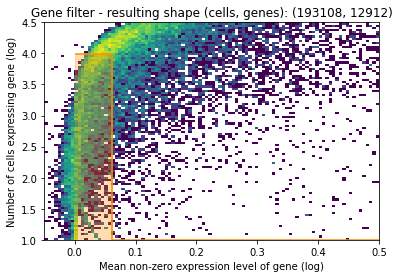

In [7]:
nonz_mean_cutoff = np.log10(1.15)
cell_count_cutoff = np.log10(10)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.05)

min_genes = 100  

rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(adata_snrna_raw, min_genes=min_genes)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

adata_snrna_raw.var['n_cells'] = np.array((adata_snrna_raw.X > 0).sum(0)).flatten()
adata_snrna_raw.var['nonz_mean'] = np.array(adata_snrna_raw.X.sum(0)).flatten() / adata_snrna_raw.var['n_cells']
    
fig, ax = plt.subplots()
ax.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
               np.log10(adata_snrna_raw.var['n_cells']), bins=100,
               norm=mpl.colors.LogNorm(),
               range=[[-0.05,0.5], [1,4.5]]);
ax.axvspan(0,nonz_mean_cutoff, ymin=0.0, ymax=(cell_count_cutoff2-1)/3.5, color='darkorange', alpha=.3)
ax.axvspan(nonz_mean_cutoff,np.max(np.log10(adata_snrna_raw.var['nonz_mean'])), 
               ymin=0.0, ymax=(cell_count_cutoff-1)/3.5, color='darkorange', alpha=.3)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='darkorange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='darkorange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='darkorange');
plt.xlabel("Mean non-zero expression level of gene (log)");
plt.ylabel("Number of cells expressing gene (log)");
plt.title("Gene filter - resulting shape (cells, genes): " + str(adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2)) \
         | (np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff) \
         & np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff))].shape));
plt.show();

In [8]:
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2)) \
         | (np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff) \
         & np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff))]

In [9]:
adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var_names
adata_snrna_raw.var_names = adata_snrna_raw.var['gene_ids-1']
adata_snrna_raw.var_names.name = None

Trying to set attribute `.var` of view, copying.


In [10]:
adata_snrna_raw.raw = adata_snrna_raw

In [11]:
np.unique(adata_snrna_raw.obs['Celltypes'])

array(['AT1', 'AT2', 'B_mature', 'B_naive', 'B_plasma', 'B_plasmablast',
       'Basal', 'CD4_EM/Effector', 'CD4_TRM', 'CD4_naive/CM', 'CD8_EM',
       'CD8_EM/EMRA', 'CD8_TRM', 'CD8_TRM/EM', 'Chondrocyte', 'Ciliated',
       'DC_1', 'DC_2', 'DC_activated', 'DC_plasmacytoid', 'Deuterosomal',
       'Dividing_AT2', 'Dividing_Basal', 'Endothelia_Lymphatic',
       'Endothelia_vascular_Cap_a', 'Endothelia_vascular_Cap_g',
       'Endothelia_vascular_arterial_pulmonary',
       'Endothelia_vascular_arterial_systemic',
       'Endothelia_vascular_venous_pulmonary',
       'Endothelia_vascular_venous_systemic', 'Erythrocyte', 'Fibro_ASPN',
       'Fibro_adventitial', 'Fibro_adventitial_CCL', 'Fibro_alveolar',
       'Fibro_peribronchial', 'Fibro_perichondrial', 'ILC',
       'Ionocyte_n_Brush', 'MAIT', 'Macro_CHIT1', 'Macro_CXCL10',
       'Macro_MARCOneg_FCGBP_Trachea', 'Macro_MARCOpos_Metallothioneins',
       'Macro_alv', 'Macro_dividing', 'Macro_int', 'Macro_int_CCL',
       'Mast_cell',

Add counts matrix as `adata.raw` 

We need to make sure gene IDs on both spatial and reference objects are of the same type. Since it is now impossible to modify the raw slot we have to use gene names for spatial data as well.

In [12]:
adata_snrna_raw.obs['scDonor_snBatch']

AAACCTGGTGTGAATA-1-WTDAtest7887999-0       A32_cells
AAACGGGCAACCGCCA-1-WTDAtest7887999-0       A32_cells
AACCATGGTACAGCAG-1-WTDAtest7887999-0       A32_cells
AACGTTGGTGTCCTCT-1-WTDAtest7887999-0       A32_cells
AACTCCCTCCTAGTGA-1-WTDAtest7887999-0       A32_cells
                                             ...    
TTTGGTTGTAATGCGG-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGGTTGTGCCCTTT-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGGTTTCAAGAGTA-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGTTGAGCGAGTCA-1-WSSS_A_LNG8757929-1    A42_nuclei
TTTGTTGTCTTCTGGC-1-WSSS_A_LNG8757929-1    A42_nuclei
Name: scDonor_snBatch, Length: 193108, dtype: object

In [13]:
adata_snrna_raw.obs

,Celltypes,Celltypes_master_high,Celltypes_master_higher,Celltypes_master_higher_immune,Celltypes_master_2,Celltypes_master_3,Loc_true,Material,scsn,Donor,...,Version,Study,PoolDon,DonorPool,scDonor_snBatch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGGTGTGAATA-1-WTDAtest7887999-0,AT1,AT1,Epithelia,AT1,Epithelia,Epithelia,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,NaN,NaN,A32_cells,1943,1943,5356.07570,186.790330,3.487448
AAACGGGCAACCGCCA-1-WTDAtest7887999-0,B_plasma,B_plasma,Immune,B_cell,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,NaN,NaN,A32_cells,226,226,768.99475,5.476773,0.712199
AACCATGGTACAGCAG-1-WTDAtest7887999-0,Monocyte_CD16,Myeloid,Immune,Monocyte,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,NaN,NaN,A32_cells,847,847,1901.78920,108.158295,5.687187
AACGTTGGTGTCCTCT-1-WTDAtest7887999-0,CD8_EM/EMRA,T_NK,Immune,CD8,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,NaN,NaN,A32_cells,767,767,1783.32410,85.630554,4.801738
AACTCCCTCCTAGTGA-1-WTDAtest7887999-0,Macro_int,Myeloid,Immune,Macrophage_other,Immune,Immune,d_LowLeftPar,cells,cells,A32,...,10x3prime_v2,dissociation,NaN,NaN,A32_cells,799,799,1314.89540,97.600655,7.422694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTAATGCGG-1-WSSS_A_LNG8757929-1,Tregs,T_NK,Immune,CD4,Immune,Immune,a_Trachea,nuclei,nuclei,A42,...,NaN,NaN,A42,A42none,A42_nuclei,1468,1556,2975.57180,0.000000,0.000000
TTTGGTTGTGCCCTTT-1-WSSS_A_LNG8757929-1,SMG_Mucous,Submucosal_Glands,Epithelia,Submucosal_Glands,Epithelia,Epithelia,a_Trachea,nuclei,nuclei,A42,...,NaN,NaN,A42,A42none,A42_nuclei,2576,2723,7334.21440,0.000000,0.000000
TTTGGTTTCAAGAGTA-1-WSSS_A_LNG8757929-1,Basal,Epi_Basal,Epithelia,Epi_Basal,Epithelia,Epithelia,a_Trachea,nuclei,nuclei,A42,...,NaN,NaN,A42,A42none,A42_nuclei,481,500,626.38947,0.000000,0.000000
TTTGTTGAGCGAGTCA-1-WSSS_A_LNG8757929-1,SMG_Mucous,Submucosal_Glands,Epithelia,Submucosal_Glands,Epithelia,Epithelia,a_Trachea,nuclei,nuclei,A42,...,NaN,NaN,A42,A42none,A42_nuclei,2416,2576,6651.60060,0.000000,0.000000


## 2. Show UMAP of cells and locations

/nfs/team283/vk7/software/miniconda3farm5/envs/test_pyro/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'Celltypes' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/test_pyro/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'Celltypes_master_high' as categorical
/nfs/team283/vk7/software/miniconda3farm5/envs/test_pyro/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories w

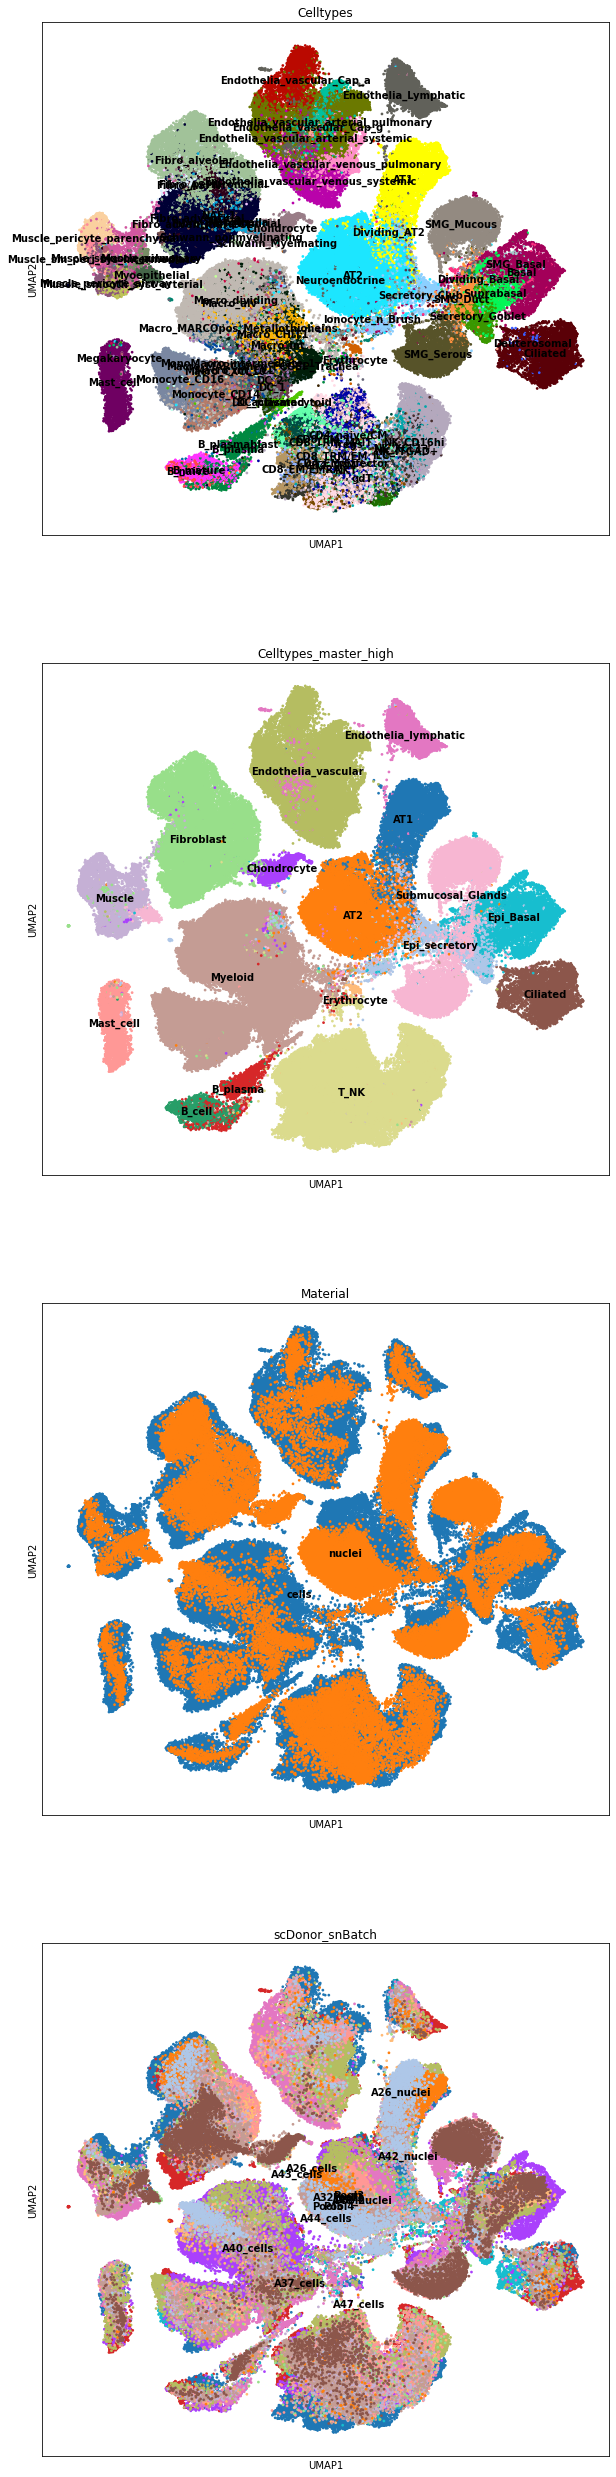

In [14]:
rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_snrna_raw, color=['Celltypes', 'Celltypes_master_high', 
                                   'Material', 'scDonor_snBatch'],
           color_map = 'RdPu', ncols = 1, legend_loc='on data',
           size=30,
           legend_fontsize=10)

Now we look at the UMAP of Visium spots

In [15]:
print(adata_snrna_raw.X.data)
adata_snrna_raw.X.data = np.round(adata_snrna_raw.X.data)
adata_snrna_raw.X.data

[1.97858    1.97858    0.98393506 ... 0.9769759  0.9701275  0.97543436]


array([2., 2., 1., ..., 1., 1., 1.], dtype=float32)

In [16]:
# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_snrna_raw, batch_key='Sample', labels_key='Celltypes',
                        categorical_covariate_keys=['scDonor_snBatch']
                       )
scvi.data.view_anndata_setup(adata_snrna_raw)

INFO     Using batches from adata.obs["Sample"]                                              
INFO     Using labels from adata.obs["Celltypes"]                                            
INFO     Using data from adata.X                                                             


/nfs/team283/vk7/software/miniconda3farm5/envs/test_pyro/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 193108 cells, 12912 vars, 75      
         batches, 79 labels, and 0 proteins. Also registered 1 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team283/vk7/software/miniconda3farm5/envs/test_pyro/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.3.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 193108 │
│             Vars             │ 12912  │
│            Labels            │   79   │
│           Batches            │   75   │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   1    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │                adata.X                 │
│ batch_indices │        adata.obs['_scvi_batch']        │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
└───────────────┴────────────────────────────────────────┘

                                    Label Categories                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃               Categories               ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Celltypes'] │                  AT1                   │          0          │
│                        │                  AT2                   │          1          │
│                        │                B_mature                │          2          │
│                        │                B_naive                 │          3          │
│                        │                B_plasma                │          4          │
│                        │             B_plasmablast              │          5          │
│                        │                 Basal                  │          6          │
│                        │            CD4_EM/Effector             │          7          │
│                        │                CD4_TRM                 │          8          │
│                        │              CD4_naive/CM              │          9          │
│                        │                 CD8_EM                 │         10          │
│                        │              CD8_EM/EMRA               │         11          │
│                        │                CD8_TRM                 │         12          │
│                        │               CD8_TRM/EM               │         13          │
│                        │              Chondrocyte               │         14          │
│                        │                Ciliated                │         15          │
│                        │                  DC_1                  │         16          │
│                        │                  DC_2                  │         17          │
│                        │              DC_activated              │         18          │
│                        │            DC_plasmacytoid             │         19          │
│                        │              Deuterosomal              │         20          │
│                        │              Dividing_AT2              │         21          │
│                        │             Dividing_Basal             │         22          │
│                        │          Endothelia_Lymphatic          │         23          │
│                        │       Endothelia_vascular_Cap_a        │         24          │
│                        │       Endothelia_vascular_Cap_g        │         25          │
│                        │ Endothelia_vascular_arterial_pulmonary │         26          │
│                        │ Endothelia_vascular_arterial_systemic  │         27          │
│                        │  Endothelia_vascular_venous_pulmonary  │         28          │
│                        │  Endothelia_vascular_venous_systemic   │         29          │
│                        │              Erythrocyte               │         30          │
│                        │               Fibro_ASPN               │         31          │
│                        │           Fibro_adventitial            │         32          │
│                        │         Fibro_adventitial_CCL          │         33          │
│                        │             Fibro_alveolar             │         34          │
│                        │          Fibro_peribronchial           │         35          │
│                        │          Fibro_perichondrial           │         36          │
│                        │                  ILC                   │         37          │
│                        │            Ionocyte_n_Brush            │         38          │
│                        │                  MAIT                  │         39          │
│                        │              

                        Batch Categories                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │  5841STDY7991475  │          0          │
│                     │  5841STDY7991476  │          1          │
│                     │  5841STDY7991477  │          2          │
│                     │  5841STDY7991478  │          3          │
│                     │  5841STDY7991479  │          4          │
│                     │  5841STDY7991482  │          5          │
│                     │  5841STDY7991483  │          6          │
│                     │  5841STDY7991484  │          7          │
│                     │  5841STDY7991485  │          8          │
│                     │  5841STDY7991486  │          9          │
│                     │  5841STDY7991487  │         10          │
│                     │ HCATisStab7732261 │         11          │
│                     │ HCATisStab7732262 │         12          │
│                     │ HCATisStab7732263 │         13          │
│                     │ HCATisStab7732264 │         14          │
│                     │ HCA_A_LNG9387709  │         15          │
│                     │ HCA_A_LNG9387710  │         16          │
│                     │ HCA_A_LNG9387711  │         17          │
│                     │ HCA_A_LNG9387712  │         18          │
│                     │ HCA_A_LNG9387713  │         19          │
│                     │ HCA_A_LNG9387714  │         20          │
│                     │ HCA_A_LNG9387715  │         21          │
│                     │ HCA_A_LNG9387716  │         22          │
│                     │ HCA_A_LNG9387717  │         23          │
│                     │ HCA_A_LNG9387718  │         24          │
│                     │    WSSS8015042    │         25          │
│                     │    WSSS8015043    │         26          │
│                     │    WSSS8015044    │         27          │
│                     │    WSSS8015045    │         28          │
│                     │    WSSS8015046    │         29          │
│                     │    WSSS8015047    │         30          │
│                     │    WSSS8015048    │         31          │
│                     │    WSSS8015049    │         32          │
│                     │    WSSS8015050    │         33          │
│                     │    WSSS8015051    │         34          │
│                     │    WSSS8062679    │         35          │
│                     │    WSSS8062680    │         36          │
│                     │    WSSS8062681    │         37          │
│                     │    WSSS8062682    │         38          │
│                     │    WSSS8123922    │         39          │
│                     │    WSSS8123923    │         40          │
│                     │    WSSS8123924    │         41          │
│                     │    WSSS8123925    │         42          │
│                     │    WSSS8123926    │         43          │
│                     │    WSSS8123927    │         44          │
│                     │    WSSS8123928    │         45          │
│                     │    WSSS8123929    │         46          │
│                     │    WSSS8123930    │         47          │
│                     │    WSSS8123931    │         48          │
│                     │ WSSS_A_LNG8620059 │         49          │
│                     │ WSSS_A_LNG8620060 │         50          │
│                     │ WSSS_A_LNG8620061 │         51          │
│                     │ WSSS_A_LNG8620062 │         52          │
│                     │ WSSS_A_LNG8620063 │         53          │
│                     │ WSSS_A_LNG8620064 │         54          │
│                     │ WSSS_A_LNG8620065 │         55          │
│                     │ WSSS_A_LNG862006

                    Extra Categorical Variables                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['scDonor_snBatch'] │ A26_cells  │          0          │
│                              │ A26_nuclei │          1          │
│                              │ A32_cells  │          2          │
│                              │ A37_cells  │          3          │
│                              │ A40_cells  │          4          │
│                              │ A42_nuclei │          5          │
│                              │ A43_cells  │          6          │
│                              │ A44_cells  │          7          │
│                              │ A47_cells  │          8          │
│                              │ A48_nuclei │          9          │
│                              │   Pool1    │         10          │
│                              │   Pool2    │         11          │
│                              │   Pool3    │         12          │
│                              │   Pool4    │         13          │
│                              │   Pool5    │         14          │
│                              │            │                     │
└──────────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/test_pyro/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:37<00:00, 26.81it/s]


TypeError: Incompatible object (Dataset) already exists

Above error raised while writing key 'means_per_cluster_mu_fg_CD8_EM/EMRA' of <class 'h5py._hl.group.Group'> from /.

Above error raised while writing key 'means_per_cluster_mu_fg_CD8_EM/EMRA' of <class 'h5py._hl.group.Group'> from /.

Above error raised while writing key 'varm/means_per_cluster_mu_fg' of <class 'h5py._hl.files.File'> from /.

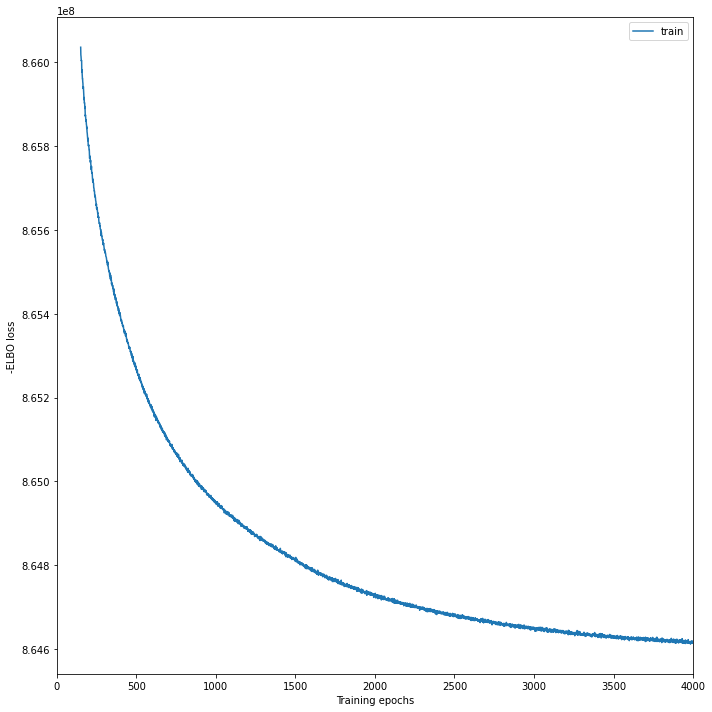

In [18]:
# create and train the model
import pyro
from cell2location.models import RegressionModel
mod = RegressionModel(
    adata_snrna_raw,
    #amortised=True, encoder_mode="single",
    #encoder_kwargs={'dropout_rate': 0.1}
) 

mod.train(max_epochs=4000, 
          batch_size=2476, 
          train_size=1,
          #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(150)

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_snrna_raw = mod.export_posterior(
    adata_snrna_raw, sample_kwargs={'num_samples': 1000, 'batch_size': 2476, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_ref_run_name}", overwrite=True)
# can be loaded later like this:
# mod = cell2location.models.RegressionModel.load(f"{scvi_run_name}_ref", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw.write(adata_file)
adata_file

In [36]:
from re import sub
adata_snrna_raw.varm['means_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['means_per_cluster_mu_fg'].columns]
adata_snrna_raw.varm['stds_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['stds_per_cluster_mu_fg'].columns]
adata_snrna_raw.varm['q05_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['q05_per_cluster_mu_fg'].columns]
adata_snrna_raw.varm['q95_per_cluster_mu_fg'].columns = \
[sub('/', '_', c) for c in adata_snrna_raw.varm['q95_per_cluster_mu_fg'].columns]
adata_snrna_raw.uns['mod']['factor_names'] = \
[sub('/', '_', c) for c in adata_snrna_raw.uns['mod']['factor_names']]


# Save anndata object with results
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw.write(adata_file)
adata_file

'/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results//non_amortised/v0_Adam_4000iter_snsc_selection_CCLplasma_v3Ref/sc.h5ad'

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

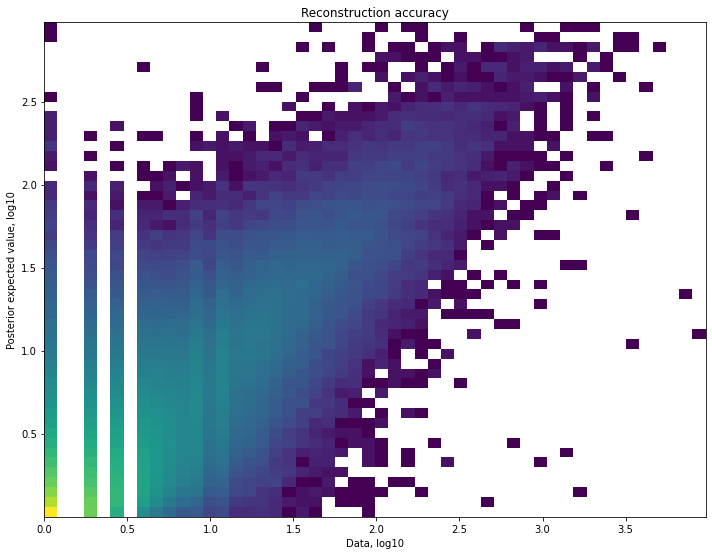

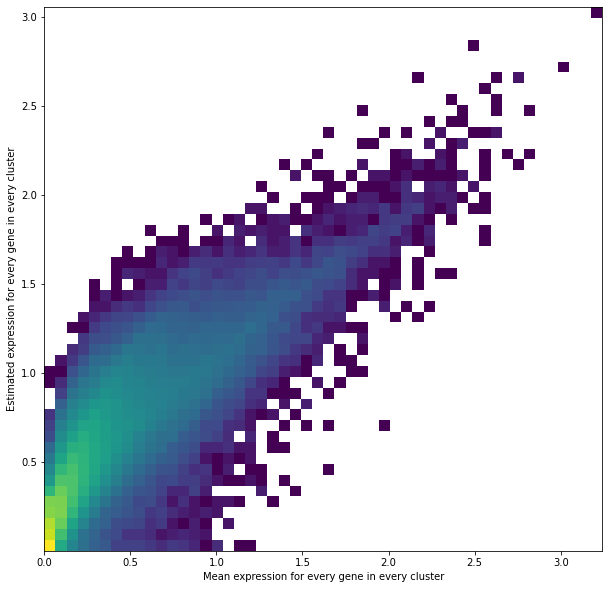

In [37]:
mod.plot_QC()

In [38]:
#mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}_snsc_selection_ref", adata_snrna_raw)
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

In [39]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,AT1,AT2,B_mature,B_naive,B_plasma
ENSG00000187634,0.003923,0.001806,0.002212,0.004823,0.011074
ENSG00000188976,0.353068,0.401745,0.254370,0.293211,0.264124
ENSG00000188290,0.793359,0.081513,0.013442,0.009298,0.005323
ENSG00000187608,0.149437,0.002997,0.085343,0.031012,0.072511
ENSG00000188157,2.676636,0.738708,0.004124,0.005188,0.005811


In [40]:
inf_aver.sum()

AT1                 13770.023438
AT2                 18098.552734
B_mature             5329.946777
B_naive              3933.812012
B_plasma             7678.750000
                        ...     
Secretory_Club      12981.500000
Secretory_Goblet    24891.703125
Suprabasal          21872.349609
Tregs                3987.052490
gdT                  3895.932373
Length: 79, dtype: float32

Here we show how to perform the first step in one function run - train cell2location model to learn cell locations. Results are shown below and saved to:  

In [41]:
results_folder

'/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results/'

Modules and their versions used for this analysis

In [42]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

re 2.2.1
ipykernel._version 6.4.2
json 2.0.9
jupyter_client._version 7.0.6
traitlets._version 5.1.1
traitlets 5.1.1
logging 0.5.1.2
platform 1.0.8
_ctypes 1.1.0
ctypes 1.1.0
zmq.backend.cython.constants 40304
zmq.backend.cython 40304
zmq.sugar.constants 40304
zmq.sugar.version 22.3.0
zmq.sugar 22.3.0
zmq 22.3.0
argparse 1.1
zlib 1.0
colorama 0.4.4
_curses b'2.2'
dateutil 2.8.2
six 1.16.0
_decimal 1.70
decimal 1.70
jupyter_core.version 4.9.1
jupyter_core 4.9.1
entrypoints 0.3
jupyter_client 7.0.6
ipykernel 6.4.2
IPython.core.release 7.29.0
pygments 2.10.0
ptyprocess 0.7.0
pexpect 4.8.0
decorator 5.1.0
pickleshare 0.7.5
backcall 0.2.0
wcwidth 0.2.5
prompt_toolkit 3.0.21
parso 0.8.2
jedi 0.18.0
urllib.request 3.9
IPython 7.29.0
ipython_genutils._version 0.2.0
ipython_genutils 0.2.0
distutils 3.9.7
debugpy 1.5.1
xmlrpc.client 3.9
socketserver 0.4
http.server 0.6
pkg_resources._vendor.appdirs 1.4.3
pkg_resources.extern.appdirs 1.4.3
pkg_resources._vendor.packaging.__about__ 20.4
pkg_resourc